In [1]:
def decode_routes(permutation, demands, Q):
    """
    permutation: lista de clientes [c1, c2, ..., cn]
    demands: dict {cliente -> demanda}
    Q: capacidad del vehículo
    return: lista de rutas, cada ruta es [depot, ..., depot]
    """
    routes = []
    current_route = []
    current_load = 0

    for client in permutation:
        d = demands[client]
        # Si cabe, lo meto en la ruta actual
        if current_load + d <= Q:
            current_route.append(client)
            current_load += d
        else:
            # cierro la ruta actual y abro una nueva
            routes.append(current_route)
            current_route = [client]
            current_load = d

    if current_route:
        routes.append(current_route)

    # añadir depósito al inicio y final de cada ruta
    routes_with_depot = []
    for r in routes:
        routes_with_depot.append([0] + r + [0])

    return routes_with_depot
def evaluate_solution(permutation, instance):
    """
    instance tendrá todo: distancias, demandas, Q, parámetros de costos, etc.
    """
    routes = decode_routes(permutation, instance.demands, instance.Q)
    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0

    for route in routes:
        for i in range(len(route) - 1):
            a = route[i]
            b = route[i+1]
            dist = instance.distance_matrix[a][b]
            total_distance += dist

            time = dist / instance.speed  # si asumen velocidad constante
            total_time += time

            fuel_used = dist / instance.fuel_efficiency  # km / (km/l) = l
            total_fuel_cost += fuel_used * instance.fuel_price

    num_vehicles = len(routes)
    fixed_cost = num_vehicles * instance.C_fixed
    distance_cost = total_distance * instance.C_dist
    time_cost = total_time * instance.C_time

    total_cost = fixed_cost + distance_cost + time_cost + total_fuel_cost

    return total_cost, routes

import random

def swap_mutation(perm):
    i, j = random.sample(range(len(perm)), 2)
    perm[i], perm[j] = perm[j], perm[i]
    return perm

def ox_crossover(parent1, parent2):
    n = len(parent1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None] * n

    child[a:b+1] = parent1[a:b+1]

    p2_idx = 0
    for i in range(n):
        if child[i] is None:
            while parent2[p2_idx] in child:
                p2_idx += 1
            child[i] = parent2[p2_idx]

    return child

import random
import numpy as np

class CVRPInstance:
    def __init__(self, distance_matrix, demands, Q,
                 C_fixed, C_dist, C_time,
                 fuel_price, fuel_efficiency,
                 speed=1.0):
        self.distance_matrix = distance_matrix
        self.demands = demands          # dict {client_id -> demanda}
        self.Q = Q
        self.C_fixed = C_fixed
        self.C_dist = C_dist
        self.C_time = C_time
        self.fuel_price = fuel_price
        self.fuel_efficiency = fuel_efficiency
        self.speed = speed

        self.clients = sorted([c for c in demands.keys() if c != 0])


def decode_routes(permutation, demands, Q):
    routes = []
    current_route = []
    current_load = 0

    for client in permutation:
        d = demands[client]
        if current_load + d <= Q:
            current_route.append(client)
            current_load += d
        else:
            routes.append(current_route)
            current_route = [client]
            current_load = d

    if current_route:
        routes.append(current_route)

    routes_with_depot = []
    for r in routes:
        routes_with_depot.append([0] + r + [0])

    return routes_with_depot


def evaluate_solution(permutation, instance: CVRPInstance):
    routes = decode_routes(permutation, instance.demands, instance.Q)
    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0

    for route in routes:
        for i in range(len(route) - 1):
            a = route[i]
            b = route[i+1]
            dist = instance.distance_matrix[a][b]
            total_distance += dist

            time = dist / instance.speed
            total_time += time

            fuel_used = dist / instance.fuel_efficiency
            total_fuel_cost += fuel_used * instance.fuel_price

    num_vehicles = len(routes)
    fixed_cost = num_vehicles * instance.C_fixed
    distance_cost = total_distance * instance.C_dist
    time_cost = total_time * instance.C_time

    total_cost = fixed_cost + distance_cost + time_cost + total_fuel_cost

    return total_cost, routes


def init_population(instance, pop_size):
    population = []
    for _ in range(pop_size):
        perm = instance.clients.copy()
        random.shuffle(perm)
        population.append(perm)
    return population


def tournament_selection(population, fitnesses, k=3):
    idxs = random.sample(range(len(population)), k)
    best = min(idxs, key=lambda i: fitnesses[i])
    return population[best][:] 


def swap_mutation(perm, p_mut):
    perm = perm[:] 
    if random.random() < p_mut:
        i, j = random.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]
    return perm


def ox_crossover(parent1, parent2, p_crossover):
    if random.random() > p_crossover:
        return parent1[:], parent2[:]

    n = len(parent1)
    a, b = sorted(random.sample(range(n), 2))
    child1 = [None] * n
    child2 = [None] * n

    # segmento de parent1 en child1; de parent2 en child2
    child1[a:b+1] = parent1[a:b+1]
    child2[a:b+1] = parent2[a:b+1]

    # fill child1 con parent2
    p2_idx = 0
    for i in range(n):
        if child1[i] is None:
            while parent2[p2_idx] in child1:
                p2_idx += 1
            child1[i] = parent2[p2_idx]

    # fill child2 con parent1
    p1_idx = 0
    for i in range(n):
        if child2[i] is None:
            while parent1[p1_idx] in child2:
                p1_idx += 1
            child2[i] = parent1[p1_idx]

    return child1, child2


def run_ga(instance: CVRPInstance,
           pop_size=50,
           generations=200,
           p_crossover=0.9,
           p_mut=0.2,
           tournament_k=3,
           seed=None):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    population = init_population(instance, pop_size)

    # evaluar población inicial
    fitnesses = []
    for perm in population:
        cost, _ = evaluate_solution(perm, instance)
        fitnesses.append(cost)

    best_cost = min(fitnesses)
    best_perm = population[int(np.argmin(fitnesses))][:]
    history_best = [best_cost]

    for gen in range(generations):
        new_population = []

        # elitismo: conservar el mejor
        new_population.append(best_perm[:])

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, k=tournament_k)
            parent2 = tournament_selection(population, fitnesses, k=tournament_k)

            child1, child2 = ox_crossover(parent1, parent2, p_crossover)
            child1 = swap_mutation(child1, p_mut)
            child2 = swap_mutation(child2, p_mut)

            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)

        population = new_population

        # reevaluar
        fitnesses = []
        for perm in population:
            cost, _ = evaluate_solution(perm, instance)
            fitnesses.append(cost)

        gen_best_cost = min(fitnesses)
        gen_best_perm = population[int(np.argmin(fitnesses))][:]

        if gen_best_cost < best_cost:
            best_cost = gen_best_cost
            best_perm = gen_best_perm

        history_best.append(best_cost)

    best_routes = decode_routes(best_perm, instance.demands, instance.Q)
    return best_cost, best_routes, best_perm, history_best


In [2]:
import math
import pandas as pd

# lec
clients_df   = pd.read_csv("clients.csv")
depots_df    = pd.read_csv("depots.csv")
vehicles_df  = pd.read_csv("vehicles.csv")
params_df    = pd.read_csv("parameters_base.csv")   # el que tiene fuel_price y fuel_efficiency_typical

# depot
depot_row = depots_df.iloc[0]
depot_lat = float(depot_row["Latitude"])
depot_lon = float(depot_row["Longitude"])
depot_id_ext = str(depot_row["DepotID"])  # CD01

# clients
clients_df = clients_df.copy()
clients_df["InternalID"] = range(1, len(clients_df) + 1)

# Mapeos
idx_to_client_ext = {row.InternalID: str(row.ClientID) for row in clients_df.itertuples()}
client_ext_to_idx = {v: k for k, v in idx_to_client_ext.items()}

# coords

# coords[i] = (lat, lon) para nodo i (0 = depósito)
coords = {0: (depot_lat, depot_lon)}
for row in clients_df.itertuples():
    coords[row.InternalID] = (float(row.Latitude), float(row.Longitude))

# demands[i] = demanda del cliente i; demanda del depósito = 0
demands = {0: 0.0}
for row in clients_df.itertuples():
    demands[row.InternalID] = float(row.Demand)

# M[][] distancias Haversine

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2.0)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda / 2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

num_nodes = len(clients_df) + 1   # 0..n
distance_matrix = [[0.0]*num_nodes for _ in range(num_nodes)]

for i in range(num_nodes):
    lat_i, lon_i = coords[i]
    for j in range(num_nodes):
        if i == j:
            distance_matrix[i][j] = 0.0
        else:
            lat_j, lon_j = coords[j]
            distance_matrix[i][j] = haversine_km(lat_i, lon_i, lat_j, lon_j)

# params

C_fixed = 50000.0   # COP/vehículo
C_dist  = 2500.0    # COP/km
C_time  = 7600.0    # COP/hora

# Desde parameters_basse.csv:
fuel_price = float(params_df.loc[params_df["Parameter"]=="fuel_price","Value"].iloc[0])
fuel_eff   = float(params_df.loc[params_df["Parameter"]=="fuel_efficiency_typical","Value"].iloc[0])

speed_kmh = 40.0

# cap homogénea Q para el CVRP simplificado
Q = int(vehicles_df["Capacity"].mean())   # por ejemplo, ~105 para este caso
print("Capacidad homogénea Q para el GA:", Q)

# instatcnia cvrp --D Ga

instance_base = CVRPInstance(
    distance_matrix = distance_matrix,
    demands         = demands,      # dict {0..n}
    Q               = Q,
    C_fixed         = C_fixed,
    C_dist          = C_dist,
    C_time          = C_time,
    fuel_price      = fuel_price,
    fuel_efficiency = fuel_eff,
    speed           = speed_kmh
)

print("Instancia CVRP Caso Base creada. Nodos:", num_nodes-1, "clientes.")
print("Fuel price:", fuel_price, "COP/galón  |  Fuel efficiency:", fuel_eff, "km/galón")


Capacidad homogénea Q para el GA: 104
Instancia CVRP Caso Base creada. Nodos: 24 clientes.
Fuel price: 16300.0 COP/galón  |  Fuel efficiency: 30.0 km/galón


In [3]:
# Correr el GA para el Caso Base

best_cost, best_routes, best_perm, history_best = run_ga(
    instance_base,
    pop_size      = 80,    #  ajustar
    generations   = 300,   #  ajustar
    p_crossover   = 0.9,
    p_mut         = 0.2,
    tournament_k  = 3,
    seed          = 42     # reproducibilidad
)

print("results")
print("Mejor costo encontrado:", best_cost)
print("Numero de vehículos (rutas):", len(best_routes))
print("Rutas (nodos internos):")
for r in best_routes:
    print(" ", r)


results
Mejor costo encontrado: 723284.0622742594
Numero de vehículos (rutas): 4
Rutas (nodos internos):
  [0, 20, 23, 3, 17, 11, 8, 0]
  [0, 6, 4, 15, 22, 13, 14, 0]
  [0, 5, 9, 24, 16, 10, 1, 18, 0]
  [0, 12, 21, 7, 19, 2, 0]



Rutas (ClientID):
  1 - 20 - 23 - 3 - 17 - 11 - 8 - 1
  1 - 6 - 4 - 15 - 22 - 13 - 14 - 1
  1 - 5 - 9 - 24 - 16 - 10 - 1 - 18 - 1
  1 - 12 - 21 - 7 - 19 - 2 - 1


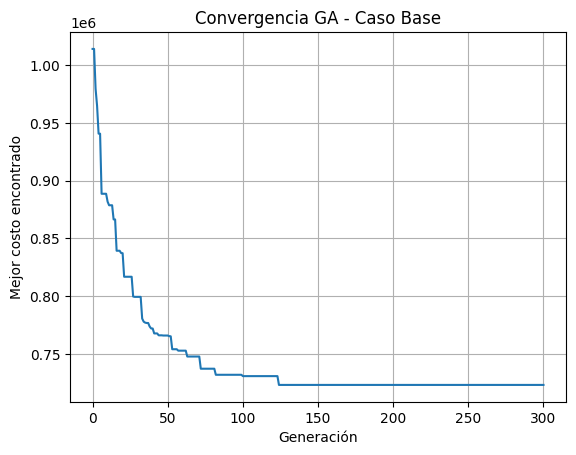

In [4]:
def pretty_route(route_internal):
    """
    route_internal: lista de enteros, por ejemplo [0, 3, 5, 0]
    Devuelve string tipo 'CD01 - 3 - 5 - CD01'
    """
    parts = []
    for nid in route_internal:
        if nid == 0:
            parts.append(depot_id_ext)  # CD01
        else:
            parts.append(str(idx_to_client_ext[nid]))
    return " - ".join(parts)

print("\nRutas (ClientID):")
for r in best_routes:
    print(" ", pretty_route(r))

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_best)
plt.xlabel("Generación")
plt.ylabel("Mejor costo encontrado")
plt.title("Convergencia GA - Caso Base")
plt.grid(True)
plt.show()


# Verificacion Meta

In [5]:
import pandas as pd


# Depot estandarizado (CD01)
depot_std_id = str(depots_df.iloc[0]["StandardizedID"])

# Cliente estandarizado: InternalID -> C00i
idx_to_client_std = {
    row.InternalID: str(row.StandardizedID)
    for row in clients_df.itertuples()
}

# Vehículos estandarizados
vehicle_std_ids = vehicles_df["StandardizedID"].tolist()


rows = []

for k, route in enumerate(best_routes):
    # Asignar un vehículo estándar a esta ruta
    if k < len(vehicle_std_ids):
        vehicle_id = vehicle_std_ids[k]
    else:
        vehicle_id = f"V{str(k+1).zfill(3)}"

    # Secuencia de nodos internos (0 = depósito, 1..n = clientes)
    internal_clients = [nid for nid in route if nid != 0]

    # Carga inicial = suma de demandas de todos los clientes de la ruta
    initial_load = sum(instance_base.demands[i] for i in internal_clients)

    # Número de clientes servidos
    clients_served = len(internal_clients)

    # Lista de demandas
    demands_satisfied_list = [int(instance_base.demands[i]) for i in internal_clients]
    demands_satisfied_str = "-".join(str(d) for d in demands_satisfied_list)

    # Secuencia de ruta en IDs estandarizados (CD01, C00i, ..., CD01)
    seq_std = []
    for nid in route:
        if nid == 0:
            seq_std.append(depot_std_id)  # CD01
        else:
            seq_std.append(idx_to_client_std[nid])
    route_sequence_str = "-".join(seq_std)

    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0

    for i in range(len(route) - 1):
        a = route[i]
        b = route[i+1]
        dist = instance_base.distance_matrix[a][b]
        total_distance += dist

        time_h = dist / instance_base.speed          # horas
        total_time += time_h

        fuel_used = dist / instance_base.fuel_efficiency   # galones
        total_fuel_cost += fuel_used * instance_base.fuel_price

    # Costos por componente (por vehículo/ruta)
    distance_cost = total_distance * instance_base.C_dist
    time_cost     = total_time * instance_base.C_time
    fixed_cost    = instance_base.C_fixed

    total_cost_route = fixed_cost + distance_cost + time_cost + total_fuel_cost

    rows.append({
        "VehicleId":      vehicle_id,
        "DepotId":        depot_std_id,
        "InitialLoad":    round(initial_load, 2),
        "RouteSequence":  route_sequence_str,
        "ClientsServed":  clients_served,
        "DemandsSatisfied": demands_satisfied_str,
        "TotalDistance":  round(total_distance, 4),
        "TotalTime":      round(total_time, 4),
        "FuelCost":       round(total_fuel_cost, 2),
        "TotalCost":      round(total_cost_route, 2)
    })

verif_ga_df = pd.DataFrame(rows, columns=[
    "VehicleId","DepotId","InitialLoad","RouteSequence",
    "ClientsServed","DemandsSatisfied","TotalDistance",
    "TotalTime","FuelCost","TotalCost"
])

verif_filename = "verificacion_metaheuristica_GA_caso_base.csv"
verif_ga_df.to_csv(verif_filename, index=False)
verif_ga_df
sum_cost_routes = verif_ga_df["TotalCost"].sum()
print("Suma de costos por ruta:", sum_cost_routes)
print("Mejor costo del GA:", best_cost)


Suma de costos por ruta: 723284.0599999999
Mejor costo del GA: 723284.0622742594
